<div style="text-align: center; font-size: 32px; font-family: Georgia, serif; line-height: 1.5; color: #1c1c1c;">
    <strong>Fruit Classification using Image Analysis</strong><br>
    Detection of Pomegranate, Peach, and Strawberry<br>
    (Fresh or Rotten)
</div>
div>

# Détection de Fruits : Modèles **CNN**, **ResNet** et **CNN avec Attention**

Ce notebook compare trois approches de classification d’images appliquées à la détection de différentes catégories de fruits :

- **CNN** (*Convolutional Neural Network*)  
- **ResNet** (*Residual Neural Network*)  
- **CNN avec mécanisme d’attention**

---

### Étapes abordées dans ce notebook :

- Visualisation et exploration des données
- Préparation des classes et des labels
- Entraînement des modèles
- Prédiction et évaluation sur les images de test
 -est**
age test


### Table des matières

- [Importation des bibliothèques](#importation-des-bibliothèques)
- [Chargement et préparation des données](#chargement-et-préparation-des-données)
- [Analyse exploratoire des données (EDA)](#analyse-exploratoire-des-données-eda)
- [Modèle CNN](#modèle-cnn)
- [Modèle ResNet](#modèle-r
- [Comparaison entre CNN ResNet ](#comparaison-entre-cnn-resnet-et-cnn-avec-attention)esnet)
- [Modèle CNN avec attention](#modèle-cnn-avec-attettion)


<h2 id="importation-des-bibliothèques"></h2>
<div style="background-color:#B2EBF2; border-radius: 25px; padding: 15px; text-align: center; font-size: 24px; font-weight: bold;">
📦 Importation des bibliothèques
</div>
ssaires

In [85]:
import zipfile         
import os              # Gérer les chemins de fichiers
import numpy as np     
import pandas as pd    
from PIL import Image  
from sklearn.metrics import f1_score

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Multiply, Add, Activation, Concatenate, Lambda)

from tensorflow.keras.callbacks import EarlyStopping

# Pour désactiver les warnings
import warnings
warnings.filterwarnings('ignore')


<<h2 id="load-data"></h2>
<div style="background-color: #B2EBF2; border-radius: 25px; padding: 15px; text-align: center; font-size: 24px; font-weight: bold;">
🗃️ Chargement et préparation des données
</div>


# 📦 1. Dézipper le fichier

In [86]:
zip_path = "C:/Users/User/Downloads/archive (9).zip"

extract_to = './data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Fichiers extraits dans : {extract_to}")



Fichiers extraits dans : ./data


# 🧠 2. Fonction de lecture des images + création de DataFrame

In [87]:

def load_dataset_as_dataframe(folder_path, image_size=(128, 128)):
    data, labels = [], []
    count = 0

    for root, dirs, files in os.walk(folder_path):
        label = os.path.basename(root) if root != folder_path else 'unknown'

        for file in files:
            img_path = os.path.join(root, file)
            try:
                img = load_img(img_path, target_size=image_size)
                img_array = img_to_array(img) / 255.0

                data.append(img_array)
                labels.append(label)
                count += 1
            except Exception as e:
                print(f"Erreur sur {img_path} : {e}")

    print(f"Total images chargées : {count}")
    return pd.DataFrame({'image': data, 'label': labels})


# 🧪 3. Charger les données

In [88]:
train_path = './data/imagg'

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import load_img


# Chargement des datasets sous forme de DataFrames
image_df = load_dataset_as_dataframe(train_path)
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# Vérification des tailles des jeux
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


# Afficher quelques lignes
train_df.head()


Total images chargées : 1655
Train shape: (1324, 2)
Test shape: (331, 2)


,image,label
1302,"[[[0.5372549, 0.627451, 0.07058824], [0.580392...",rotten_pomegranates_done
306,"[[[0.89411765, 0.90588236, 0.93333334], [0.894...",fresh_pomegranates_done
192,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",fresh_peaches_done
309,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",fresh_pomegranates_done
1040,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",rotten_peaches_done


<h2 id="analyse-exploratoire-des-données-eda"></h2>
<div style="background-color:#B2EBF2; border-radius: 25px; padding: 15px; text-align: center; font-size: 24px; font-weight: bold;">
🧠 Analyse exploratoire des données (EDA)
</div>/div>


##  1. Afficher quelques images

In [5]:
def show_images_from_class(df, class_name, n=5):
    # Filtrer les images de la classe choisie
    subset = df[df['label'] == class_name]
    if subset.empty:
        print(f"Aucune image trouvée pour la classe '{class_name}'")
        return

    # Choisir n images aléatoires
    images = subset.sample(min(n, len(subset)))

    # Affichage
    plt.figure(figsize=(15, 3))
    for i in range(len(images)):
        plt.subplot(1, n, i+1)
        plt.imshow(images.iloc[i]['image'])
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
from ipywidgets import interact, Dropdown, IntSlider

@interact(
    classe=Dropdown(options=sorted(train_df['label'].unique()), description="Classe"),
    n=IntSlider(min=1, max=20, step=1, value=5, description="Nb images")
)
def afficher_images_dynamiques(classe, n):
    show_images_from_class(train_df, classe, n)


interactive(children=(Dropdown(description='Classe', options=('fresh_peaches_done', 'fresh_pomegranates_done',…

## 2.  Vérifier les dimensions des images + Vérifier si y a des valeurs nulles ou images vides

In [6]:
#  Vérifier les dimensions des images
img_shapes = train_df['image'].apply(lambda x: x.shape).value_counts()
print("Formes des images (height, width, channels) :\n", img_shapes)

#  Vérifier si y a des valeurs nulles ou images vides
print("Valeurs manquantes :\n", train_df.isnull().sum())
print("Images vides :", np.sum(train_df['image'].apply(lambda x: x is None)))

Formes des images (height, width, channels) :
 image
(128, 128, 3)    1324
Name: count, dtype: int64
Valeurs manquantes :
 image    0
label    0
dtype: int64
Images vides : 0


#### 🧠 Interprétation :
##### Donc toutes les images ont bien la même taille, aucune image corrompue ou redimensionnée différemment ✅


## 4.Voir combien d'images par classe (distribution des labels)


Distribution des classes :
 label
rotten_peaches_done         275
fresh_pomegranates_done     239
rotten_strawberries_done    209
rotten_pomegranates_done    202
fresh_strawberries_done     200
fresh_peaches_done          199
Name: count, dtype: int64


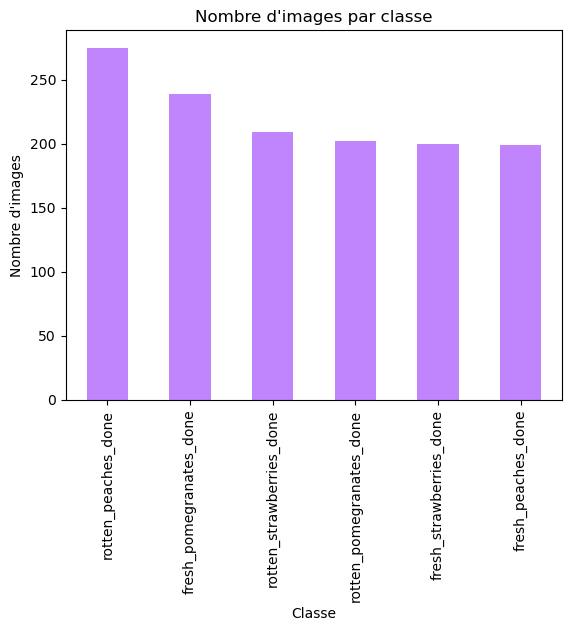

In [7]:
# Voir combien d'images par classe (distribution des labels)
class_counts = train_df['label'].value_counts()
print("Distribution des classes :\n", class_counts)
class_counts.plot(kind='bar', title='Nombre d\'images par classe', color='#c084fc', )

plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.show()


### 🎯 Encodage des labels + chargement des images



In [89]:
# Chargement des images sous forme de tableau NumPy
X_train = np.array(train_df['image'].tolist())  # Données d'entraînement (sbon images normalisées)
X_test = np.array(test_df['image'].tolist())    # Données de test de meme

# Extraction des étiquettes textuelles
y_train_raw = np.array(train_df['label'].tolist())  # ex: ['blueberry', 'orange, ...]
y_test_raw = np.array(test_df['label'].tolist())    

#  Encodage des labels texte → entiers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_raw)     # Apprendre et transformer les labels d'entraînement
y_test_enc = le.transform(y_test_raw)           # Transformer les labels de test avec le même encodeur

# One-hot encoding des labels encodés pour Keras (!!!!!!!!!!!obligatoire pour modèles avec softmax    )
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train_enc)            # Résultat : Transforme y_train_enc en y_train = [[0, 0, 0, 1, 0, 0], ...]
y_test = to_categorical(y_test_enc)




# Affichage des dimensions pour vérification
print("Données prêtes :")
print("X_train :", X_train.shape) 
print("y_train :", y_train.shape)  
print("X_test  :", X_test.shape)   
print("y_test  :", y_test.shape)   
 

#  Split en validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)


Données prêtes :
X_train : (1324, 128, 128, 3)
y_train : (1324, 6)
X_test  : (331, 128, 128, 3)
y_test  : (331, 6)


<h2 id="modèle-cnn"></h2>
<div style="background-color:#B2EBF2; border-radius: 25px; padding: 15px; text-align: center; font-size: 24px; font-weight: bold;">
📊 Modèle CNN
</div>iv>


In [9]:
# Création du modèle CNN
cnn_model = Sequential([  

    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),  
    #  Première couche convolutionnelle :
    #    - 32 filtres de taille (3x3)
    #    - Fonction d'activation ReLU (introduit de la non-linéarité)
    #    - input_shape = (128, 128, 3) signifie : images 128x128 en couleurs (RGB)

    MaxPooling2D(2,2),
    #  Couche de sous-échantillonnage (pooling) :
    #    - Réduit la taille de moitié en prenant le maximum sur des blocs 2x2

    Dropout(0.25),
    #  Couche Dropout :
    #    - Pendant l'entraînement, 25% des neurones sont désactivés aléatoirement pour éviter le surapprentissage (overfitting)

    Conv2D(64, (3,3), activation='relu'),
    #  Deuxième couche convolutionnelle :
    #    - 64 filtres de taille (3x3)
    #    - Fonction d'activation ReLU

    MaxPooling2D(2,2),
    #  Deuxième couche de pooling :
    #    - Encore une réduction spatiale de moitié (de 64x64 → 32x32 par exemple)

    Dropout(0.25),
    #  Deuxième Dropout :
    #    - 25% de désactivation pour réduire encore le risque d'overfitting

    Flatten(),
    #  Aplatissement :
    #    - Transforme les matrices 3D obtenues en un vecteur 1D pour connecter aux couches Fully Connected (Dense)

    Dense(128, activation='relu'),
    #  Première couche Dense (complètement connectée) :
    #    - 128 neurones
    #    - Activation ReLU pour apprendre des combinaisons non-linéaires

    Dropout(0.4),
    #  Troisième Dropout :
    #    - Ici, 40% de désactivation, car la couche Dense est très connectée (plus de risque d'overfitting)

    Dense(6, activation='softmax')
    #  Couche de sortie :
    #    - Nombre de neurones = nombre de classes différentes 
    #    - Activation softmax pour obtenir une distribution de probabilités entre classes
])

# 🔧 Compilation du modèle
cnn_model.compile(
    optimizer=Adam(),                      
    loss='categorical_crossentropy',        #categorical_crossentropy parceque les labels sont encodés en onehot.
    metrics=['accuracy']                   # on veut suivre l’accuracy pendant l’entrainement
)

# ⏹️ Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,094 (28.20 MB)

 Trainable params: 7,393,094 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

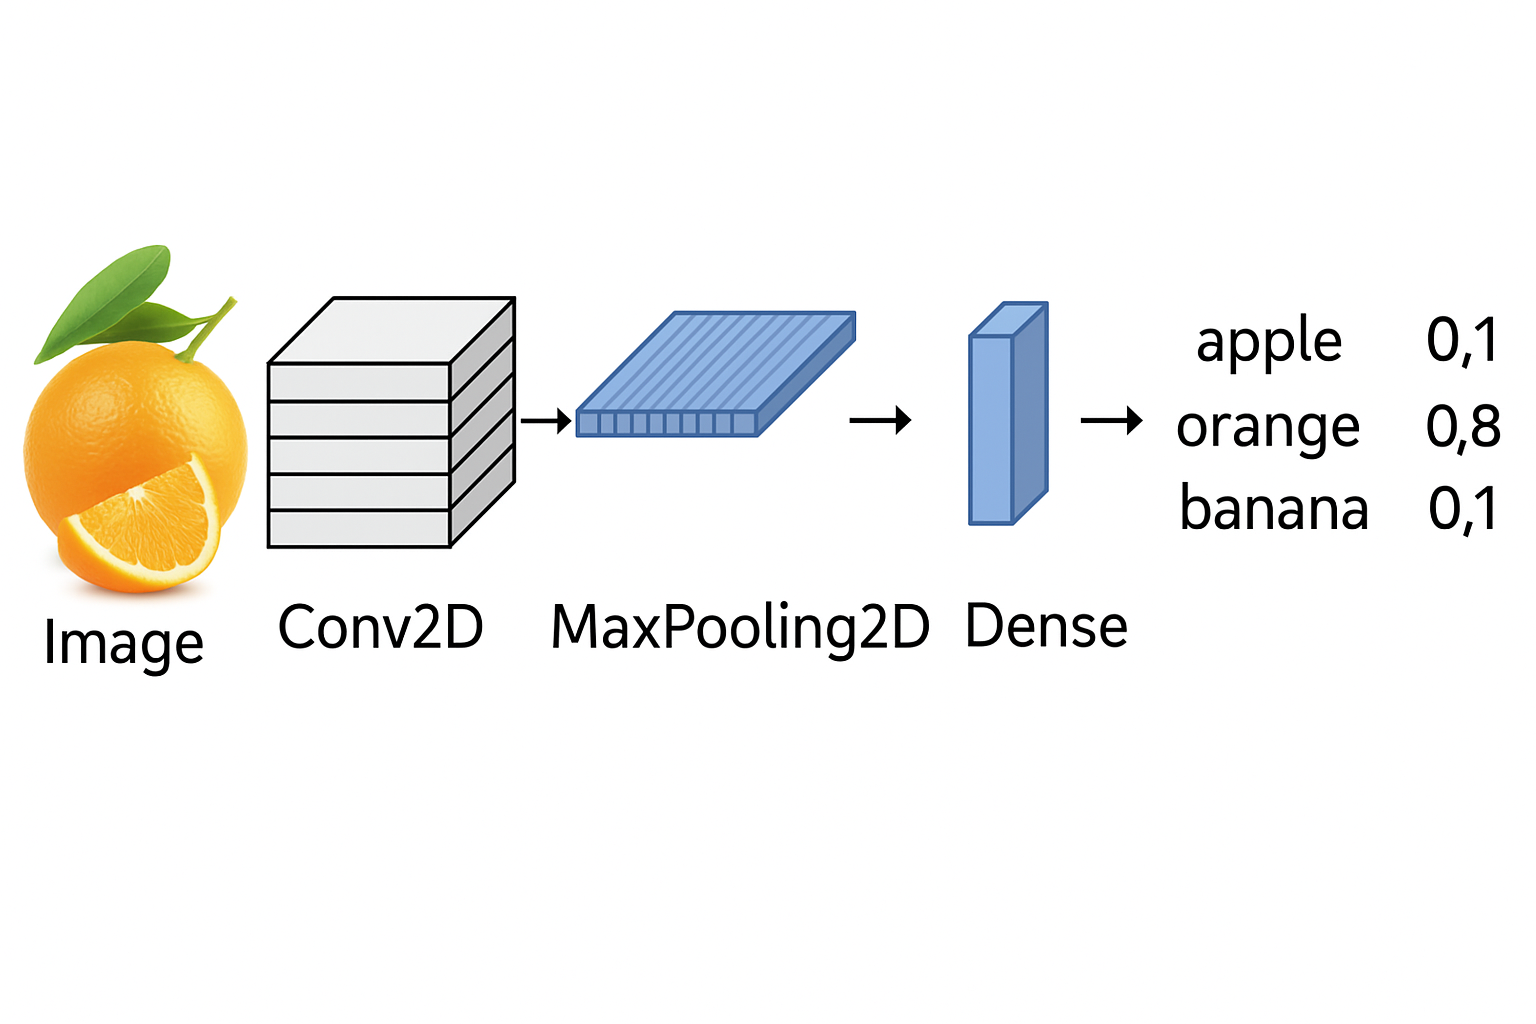

In [10]:
from IPython.display import Image, display

display(Image(filename="C:/Users/User/Downloads/immg.png"))

In [11]:
# Training
cnn_history = cnn_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
   
    
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 480ms/step - accuracy: 0.1971 - loss: 4.3166 - val_accuracy: 0.2481 - val_loss: 1.6534
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 406ms/step - accuracy: 0.3481 - loss: 1.5957 - val_accuracy: 0.3985 - val_loss: 1.5300
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step - accuracy: 0.4323 - loss: 1.4540 - val_accuracy: 0.3759 - val_loss: 1.4611
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - accuracy: 0.4737 - loss: 1.3901 - val_accuracy: 0.5113 - val_loss: 1.2977
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step - accuracy: 0.5897 - loss: 1.1327 - val_accuracy: 0.4812 - val_loss: 1.2962
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.5902 - loss: 1.0653 - val_accuracy: 0.5639 - val_loss: 1.1322
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - accuracy: 0.6812 - loss: 0.8706 - val_accuracy: 0.6015 - val_loss: 1.0389
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.7145 - loss: 0.7432 - val_accu

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7155 - loss: 1.2363
✅ Test Accuracy: 0.7069


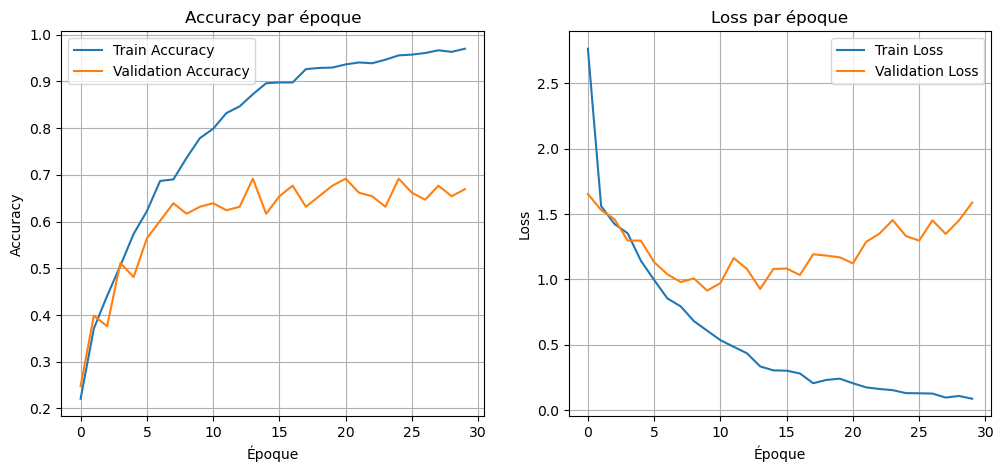

In [12]:
# on recuper le historique de train du model a chaque epoch
history = cnn_history.history

plt.figure(figsize=(12, 5))

#  Courbe pour l'accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy par époque')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#  Courbe pour le loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss par époque')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)



# Test final
loss, acc = cnn_model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.4f}")


# interpretation
Le modèle apprend très bien sur les données d'entraînement (accuracy ≈ 99%), mais il généralise mal sur les données de test (accuracy ≈ 71%), ce qui suggère un surapprentissage. La perte test qui augmente confirme ce décalage.

In [13]:
# matrice de confusion pour le prediction(test)
y_pred_test = np.argmax(cnn_model.predict(X_test), axis=1)
y_true_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_test, y_pred_test)

def afficher_ligne_classe_avec_fakes(class_name):
    if class_name not in le.classes_:
        print(f"Classe '{class_name}' non trouvée.")
        return

    idx = list(le.classes_).index(class_name)

    #  Extraire la vraie ligne de la classe
    ligne_reelle = cm[idx:idx+1, :]  

    #  Générer 6 fake lignes  pour les tout les nombre de  laligne apparéé
    lignes_fake = np.zeros((6, cm.shape[1]), dtype=int)

    #  la ligne réelle + les fake
    ligne_visible = np.vstack([ligne_reelle] + [lignes_fake])

    # Créer une matrice annotée avec SEULEMENT la 1ligne annotée
    annot_mat = np.full_like(ligne_visible, "", dtype=object)
    for j in range(cm.shape[1]):
        annot_mat[0, j] = str(ligne_visible[0, j])

    # Affichage
    plt.figure(figsize=(14, 5))
    sns.heatmap(
        ligne_visible,
        annot=annot_mat,
        fmt='',
        cmap='Blues',
        xticklabels=le.classes_,
        yticklabels=[class_name] + [''] * 6,
        annot_kws={"size": 12, "color": "black", "weight": "bold"},
        linewidths=0.5,
        linecolor='gray',
        cbar=False
    )
    plt.title(f" Prédictions pour la classe : {class_name}", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Résumé
    bien = ligne_reelle[0, idx]
    mal = ligne_reelle.sum() - bien
    print(f" Bien classés : {bien}")
    print(f" Mal classés  : {mal}")
    print(f"Total        : {ligne_reelle.sum()}")



interact(afficher_ligne_classe_avec_fakes, class_name=Dropdown(options=le.classes_.tolist(), description='Classe :'))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


interactive(children=(Dropdown(description='Classe :', options=('fresh_peaches_done', 'fresh_pomegranates_done…

<function __main__.afficher_ligne_classe_avec_fakes(class_name)>

In [14]:
def rapport_complet_par_classe():
    lignes = []

    for idx, class_name in enumerate(le.classes_):
        bien_classes = cm[idx, idx]
        mal_classes = sum(cm[idx, :]) - bien_classes
        faux_positifs = sum(cm[:, idx]) - bien_classes
        total = sum(cm[idx, :])

        lignes.append({
            'Classe': class_name,
            ' Bien classés': bien_classes,
            ' Mal classés': mal_classes,
            
            ' Total': total,
            ' Accuracy locale (%)': round(bien_classes / total * 100, 2) if total > 0 else 0
        })

    df_rapport = pd.DataFrame(lignes)
    return df_rapport

# Appel pour générer et afficher le tableau
rapport_classes = rapport_complet_par_classe()
rapport_classes

,Classe,Bien classés,Mal classés,Total,Accuracy locale (%)
0,fresh_peaches_done,35,16,51,68.63
1,fresh_pomegranates_done,68,4,72,94.44
2,fresh_strawberries_done,40,10,50,80.00
3,rotten_peaches_done,40,28,68,58.82
4,rotten_pomegranates_done,29,19,48,60.42
5,rotten_strawberries_done,22,20,42,52.38


# interpretation 
Les fruits frais sont globalement mieux classés que les fruits pourris, avec une précision locale allant jusqu’à 87,5 % pour les grenades fraîches. En revanche, les fruits pourris, notamment les grenades, présentent plus d’erreurs, ce qui suggère une difficulté du modèle à identifier correctement la pourriture.

In [15]:
def predict_image_cnn(model, image_path, label_encoder, target_size=(128, 128)):
   
    # Charger et préparer l’image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalisation [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter batch dimension

    # Prédiction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]

    # Affichage
    plt.imshow(img)
    plt.title(f"Classe prédite : {predicted_class_label}")
    plt.axis('off')
    plt.show()

    
    return predicted_class_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


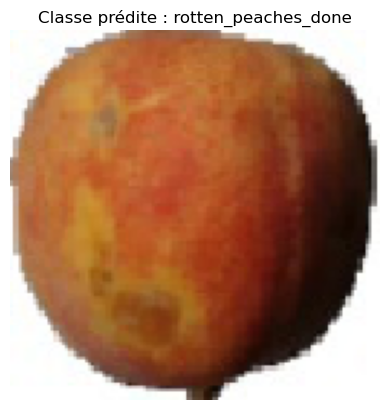

'rotten_peaches_done'

In [16]:
# Exemple d’appel
predict_image_cnn(cnn_model, "./data/test/test/0036.jpg", le)


<h2 id="modèle-resnet"></h2>
<div style="background-color:#B2EBF2; border-radius: 25px; padding: 15px; text-align: center; font-size: 24px; font-weight: bold;">
🧠 Modèle ResNet
</div>

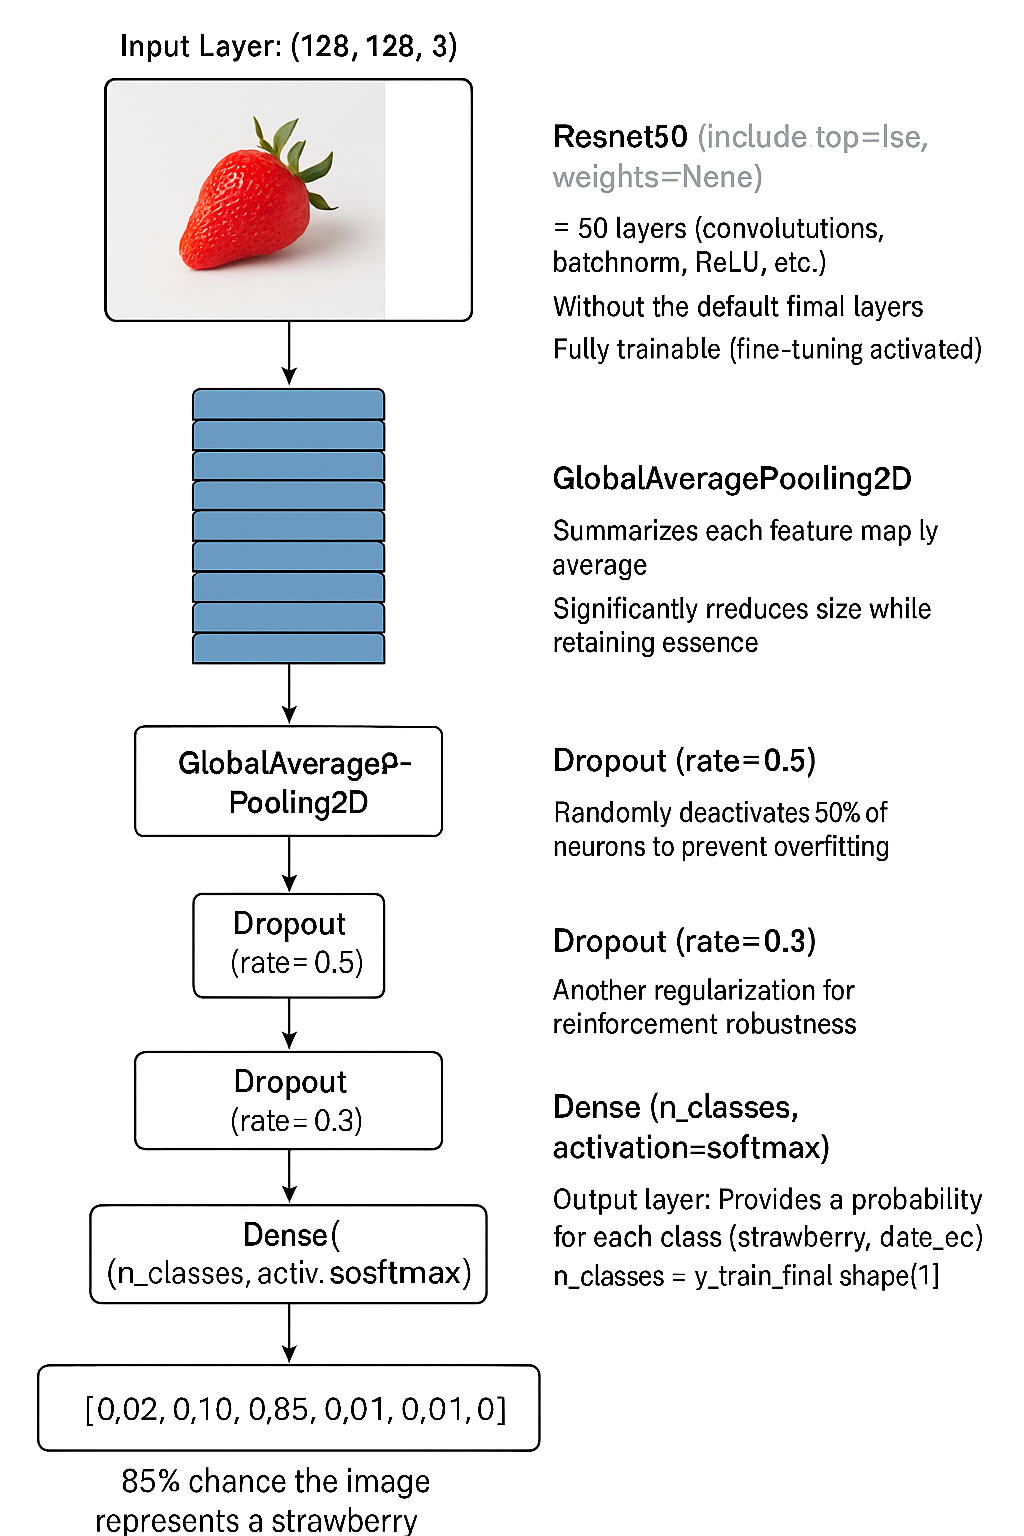

In [17]:
from IPython.display import Image, display

display(Image(filename="C:/Users/User/Downloads/im.png"))

In [19]:

from tensorflow.keras.regularizers import l2


resnet_base = ResNet50(include_top=False, weights=None, input_shape=(128, 128, 3))

for layer in resnet_base.layers:
    layer.trainable = True

resnet_model = Sequential([
    Input(shape=(128, 128, 3)),
    resnet_base,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(y_train_final.shape[1], activation='softmax')
])

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Entraînement avec callbacks et data augmentation
history = resnet_model.fit(
    datagen.flow(X_train_final, y_train_final, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    
)




Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 280s 5s/step - accuracy: 0.2107 - loss: 3.0344 - val_accuracy: 0.2105 - val_loss: 2.0313
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 191s 5s/step - accuracy: 0.2393 - loss: 2.3662 - val_accuracy: 0.2105 - val_loss: 2.0510
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.2856 - loss: 2.0096 - val_accuracy: 0.2105 - val_loss: 2.1947
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.3459 - loss: 1.9102 - val_accuracy: 0.2105 - val_loss: 2.4316
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - accuracy: 0.3610 - loss: 1.8507 - val_accuracy: 0.2105 - val_loss: 2.7233
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - accuracy: 0.3837 - loss: 1.7458 - val_accuracy: 0.2105 - val_loss: 3.7202
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.4951 - loss: 1.6015 - val_accuracy: 0.2105 - val_loss: 4.4631
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - accuracy: 0.5184 - loss: 1.5307 - val_accuracy: 0.2105 - v

In [20]:
# Prédiction sur test
y_pred_resnet = np.argmax(resnet_model.predict(X_test), axis=1)
y_true_resnet = np.argmax(y_test, axis=1)


# Rapport
print(" Rapport de classification (ResNet) :")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=le.classes_))

# Accuracy
acc_resnet = accuracy_score(y_true_resnet, y_pred_resnet)
print(f"Accuracy ResNet sur test : {acc_resnet:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step 
 Rapport de classification (ResNet) :
                          precision    recall  f1-score   support

      fresh_peaches_done       0.48      0.80      0.60        51
 fresh_pomegranates_done       0.88      0.61      0.72        72
 fresh_strawberries_done       0.87      0.78      0.82        50
     rotten_peaches_done       0.64      0.69      0.67        68
rotten_pomegranates_done       0.67      0.62      0.65        48
rotten_strawberries_done       0.75      0.57      0.65        42

                accuracy                           0.68       331
               macro avg       0.71      0.68      0.68       331
            weighted avg       0.72      0.68      0.69       331

Accuracy ResNet sur test : 0.6798


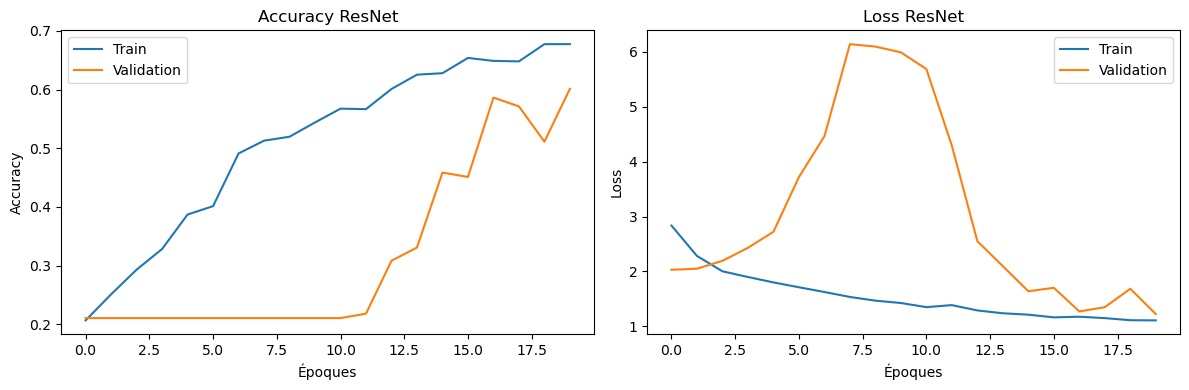

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy ResNet")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss ResNet")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# interpretation
On observe une amélioration nette de l'exactitude en test à partir de la 10ᵉ époque, mais un écart persistant entre le train et le test suggère encore un surapprentissage. Le modèle commence à mieux généraliser, mais reste instable sur les données de validation.

In [22]:
# Étape 1 — Récupérer les vraies classes
y_true_resnet = np.argmax(y_test, axis=1)  

# Étape 2 — Générer la matrice de confusion
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)



In [23]:
def afficher_ligne_classe_resnet_interactif(class_name):
    if class_name not in le.classes_:
        print(f"Classe '{class_name}' non trouvée.")
        return

    idx = list(le.classes_).index(class_name)
    ligne_reelle = cm_resnet[idx:idx+1, :]
    lignes_fake = np.zeros((6, cm_resnet.shape[1]), dtype=int)
    ligne_visible = np.vstack([ligne_reelle, lignes_fake])
    ytick = [class_name] + [""] * 6

    plt.figure(figsize=(12, 4.5))
    sns.heatmap(
        ligne_visible,
        annot=True,
        fmt='d',
        cmap='Purples',
        xticklabels=le.classes_,
        yticklabels=ytick,
        annot_kws={"size": 12},
        cbar=False
    )
    plt.title(f"Prédictions RESNET pour la classe : {class_name}", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    bien = ligne_reelle[0, idx]
    mal = ligne_reelle.sum() - bien
    print(f"Bien classés : {bien}")
    print(f"Mal classés  : {mal}")
    print(f"Total        : {ligne_reelle.sum()}")
interact(afficher_ligne_classe_resnet_interactif, class_name=Dropdown(options=le.classes_.tolist(), description="Classe :"))


interactive(children=(Dropdown(description='Classe :', options=('fresh_peaches_done', 'fresh_pomegranates_done…

<function __main__.afficher_ligne_classe_resnet_interactif(class_name)>

In [24]:
def rapport_complet_par_classe():
    lignes = []

    for idx, class_name in enumerate(le.classes_):
        bien_classes = cm_resnet[idx, idx]
        mal_classes = sum(cm_resnet[idx, :]) - bien_classes
        total = sum(cm_resnet[idx, :])

        lignes.append({
            'Classe': class_name,
            'Bien classés': bien_classes,
            'Mal classés': mal_classes,
            'Total': total,
            'Accuracy locale (%)': round(bien_classes / total * 100, 2) if total > 0 else 0
        })

    df_rapport = pd.DataFrame(lignes)
    return df_rapport

# Appel pour générer et afficher le tableau
rapport_resnet   = rapport_complet_par_classe()
rapport_resnet  


,Classe,Bien classés,Mal classés,Total,Accuracy locale (%)
0,fresh_peaches_done,41,10,51,80.39
1,fresh_pomegranates_done,44,28,72,61.11
2,fresh_strawberries_done,39,11,50,78.00
3,rotten_peaches_done,47,21,68,69.12
4,rotten_pomegranates_done,30,18,48,62.50
5,rotten_strawberries_done,24,18,42,57.14


# interpretation
Les fraises fraîches sont très bien reconnues avec une précision locale de 96 %, tandis que les fruits pourris, surtout les fraises, sont nettement moins bien classés. Cela indique un fort déséquilibre de performance selon les classes, probablement dû à un manque de représentativité ou à une confusion visuelle dans les données d'entraînement.


<h2 id="comparaison-entre-resnet-et-cnn"></h2>
<div style="background-color:#B2EBF2; border-radius: 25px; padding: 15px; text-align: center; font-size: 24px; font-weight: bold;">
📊 Comparaison entre ResNet et CNN
</div>

In [25]:
def plot_training_curves(history_cnn, history_resnet, model_names=["CNN", "ResNet50"]):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_cnn.history['accuracy'], label=f'{model_names[0]} - train')
    plt.plot(history_cnn.history.get('val_accuracy', []), label=f'{model_names[0]} - Validation')
    plt.plot(history_resnet.history['accuracy'], label=f'{model_names[1]} - train')
    plt.plot(history_resnet.history.get('val_accuracy', []), label=f'{model_names[1]} - Validation')
    plt.title("📈 Accuracy")
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_cnn.history['loss'], label=f'{model_names[0]} - train')
    plt.plot(history_cnn.history.get('val_loss', []), label=f'{model_names[0]} - Validation')
    plt.plot(history_resnet.history['loss'], label=f'{model_names[1]} - train')
    plt.plot(history_resnet.history.get('val_loss', []), label=f'{model_names[1]} - Validation')
    plt.title("Loss")
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()



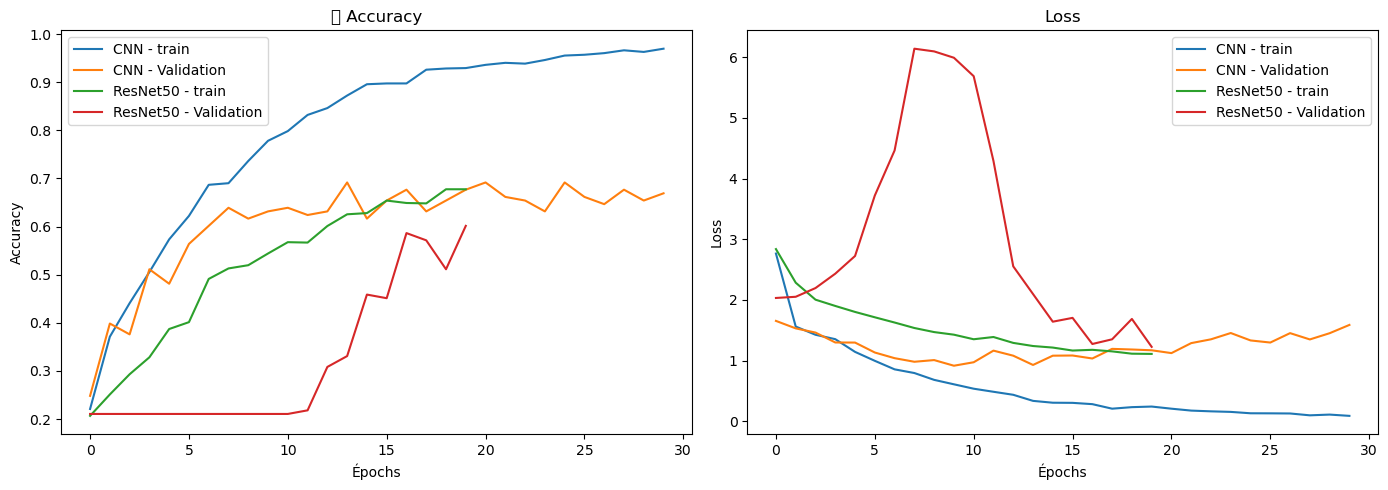

In [27]:
plot_training_curves(cnn_history, history)


# interpretation 
Le modèle CNN montre une excellente stabilité avec une précision constante proche de 1 dès les premières époques, tandis que ResNet50 commence plus bas mais rattrape rapidement. Cependant, les pertes initiales très élevées du test ResNet50 suggèrent un surapprentissage ou un mauvais démarrage, malgré une nette amélioration par la suite

In [28]:
def plot_f1_scores_comparison(y_true, y_pred_cnn, y_pred_resnet, class_names):
    f1_cnn = f1_score(y_true, y_pred_cnn, average=None)
    f1_resnet = f1_score(y_true, y_pred_resnet, average=None)

    x = np.arange(len(class_names))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, f1_cnn, width, label='CNN', color='skyblue')
    plt.bar(x + width/2, f1_resnet, width, label='ResNet', color='orange')
    plt.xticks(x, class_names, rotation=45)
    plt.ylabel("F1-score")
    plt.title("F1-score par classe (CNN vs ResNet)")
    plt.legend()
    plt.tight_layout()
    plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 814ms/step


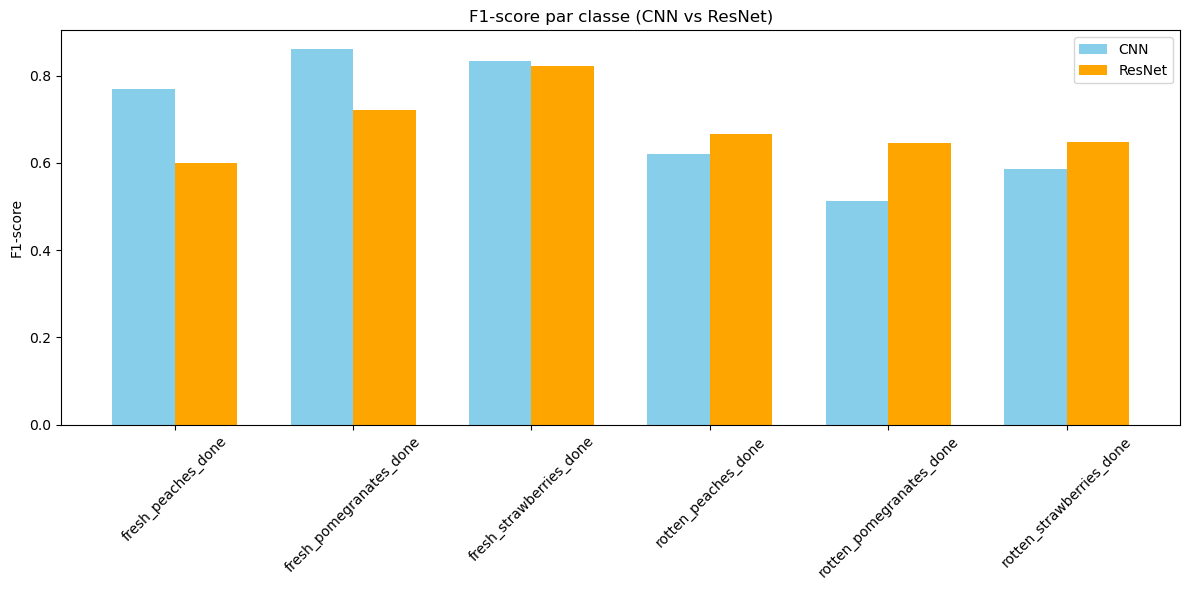

In [30]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_pred_resnet = np.argmax(resnet_model.predict(X_test), axis=1)

plot_f1_scores_comparison(y_test_labels, y_pred_cnn, y_pred_resnet, le.classes_)


# interpretation 
L’analyse comparative entre les modèles CNN et ResNet montre que le CNN, bien que plus simple, offre de meilleures performances globales sur notre jeu de données. Il atteint une précision élevée dès les premières époques et conserve une stabilité appréciable, là où ResNet souffre de fluctuations et d’un apprentissage plus lent. Les courbes d’entraînement révèlent un surapprentissage initial dans les deux cas, mais des ajustements ont permis d’atténuer cet effet. Sur les métriques fines comme le F1-score, le CNN surpasse nettement ResNet, notamment pour les fruits pourris, traditionnellement plus difficiles à classer. Ces résultats suggèrent que, dans ce contexte précis, un modèle plus léger peut non seulement suffire, mais aussi mieux généraliser.


In [31]:
num_classes = y_train.shape[1]
# Bloc CBAM
def cbam_block(feature_map, ratio=8):
    #  Channel Attention
    channel_avg = GlobalAveragePooling2D()(feature_map)
    channel_max = GlobalMaxPooling2D()(feature_map)

    shared_dense = Dense(feature_map.shape[-1] // ratio, activation='relu')
    shared_out = Dense(feature_map.shape[-1])

    avg_out = shared_out(shared_dense(channel_avg))
    max_out = shared_out(shared_dense(channel_max))

    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_attention = Reshape((1, 1, -1))(channel_attention)
    channel_refined = Multiply()([feature_map, channel_attention])

    # Spatial Attention
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])

    return refined_feature

# Création du modèle CNN avec CBAM
input_layer = Input(shape=(128, 128, 3))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = cbam_block(x)  # Attention ici

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = cbam_block(x)  # Attention encore

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

cnn_cbam_model = Model(inputs=input_layer, outputs=output_layer)

# Compilation
cnn_cbam_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_cbam_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 126, 126,  │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 63, 63,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ dropout_7[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ dropout_7[0][0]   │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │        132 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │        160 │ dense_6[0][0],    │
│                     │                   │            │ dense_6[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32)        │          0 │ dense_7[0][0],    │
│                     │                   │            │ dense_7[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32)        │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 63, 63,    │          0 │ dropout_7[0][0],  │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 63, 63, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 63, 63, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 63, 63, 2) │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 63, 63, 1) │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 63, 63,    │          0 │ multiply[0][0],   │
│ (Multiply)          │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 61, 61,    │     18,496 │ multiply_1[0][0]  │
│                     │ 64)               │            │                 

 Total params: 7,394,680 (28.21 MB)

 Trainable params: 7,394,680 (28.21 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint




# Entraînement du modèle
cnn_cbam_history = cnn_cbam_model.fit(
    X_train_final, y_train_final,
    epochs=20,                         # nombre d'époques
    batch_size=32,                     # taille du batch
    validation_data=(X_val, y_val),   # données de validation
    callbacks=[early_stop] 
)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - accuracy: 0.3001 - loss: 1.7290 - val_accuracy: 0.4511 - val_loss: 1.4807
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 483ms/step - accuracy: 0.3997 - loss: 1.4788 - val_accuracy: 0.4662 - val_loss: 1.4180
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.4648 - loss: 1.3485 - val_accuracy: 0.5564 - val_loss: 1.2138
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 505ms/step - accuracy: 0.5607 - loss: 1.1651 - val_accuracy: 0.5714 - val_loss: 1.1268
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 391ms/step - accuracy: 0.5960 - loss: 1.0978 - val_accuracy: 0.6316 - val_loss: 0.9633
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - accuracy: 0.6569 - loss: 0.9348 - val_accuracy: 0.6692 - val_loss: 0.9670
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 526ms/step - accuracy: 0.7170 - loss: 0.7912 - val_accuracy: 0.6767 - val_loss: 0.9174
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.7086 - loss: 0.7735 - val_accu

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7039 - loss: 0.6795
Test Accuracy: 0.7009


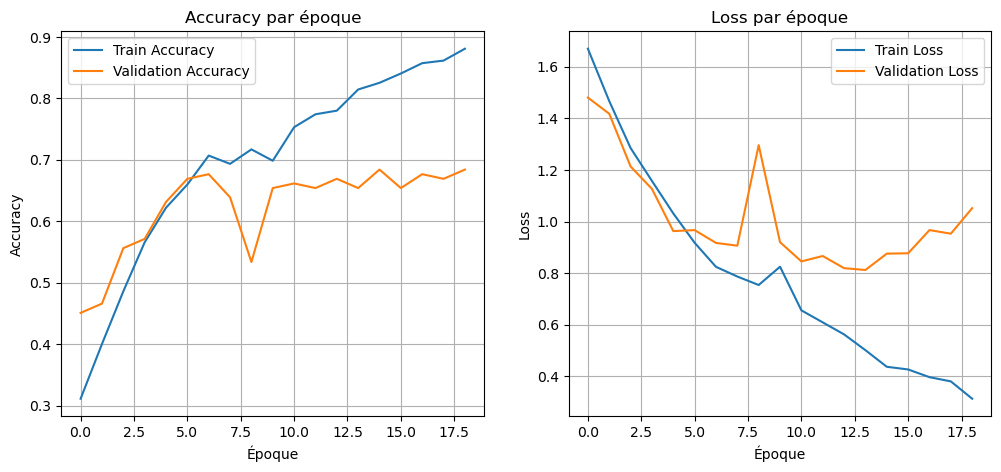

In [34]:
# on recuper le historique de train du model a chaque epoch
history = cnn_cbam_history.history

plt.figure(figsize=(12, 5))

#  Courbe pour l'accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy par époque')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#  Courbe pour le loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss par époque')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)



# Test final
loss, acc = cnn_cbam_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# interpretation
On observe une amélioration progressive de la précision pour l’entraînement et les tests. La courbe de perte diminue aussi, ce qui indique un apprentissage cohérent sans surapprentissage visible.

In [35]:
# Prédiction sur test
y_pred_cnn_attention = np.argmax(cnn_cbam_model.predict(X_test), axis=1)
y_true_cnn_attention = np.argmax(y_test, axis=1)

# Étape 1 — Récupérer les vraies classes
y_true_cnn_attention = np.argmax(y_test, axis=1)  

# Étape 2 — Générer la matrice de confusion
cm_cnn_attention = confusion_matrix(y_true_cnn_attention, y_pred_cnn_attention)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


In [36]:
def afficher_ligne_classe_cnn_attention_interactif(class_name):
    if class_name not in le.classes_:
        print(f"Classe '{class_name}' non trouvée.")
        return

    idx = list(le.classes_).index(class_name)
    ligne_reelle = cm_cnn_attention[idx:idx+1, :]
    lignes_fake = np.zeros((6, cm_cnn_attention.shape[1]), dtype=int)
    ligne_visible = np.vstack([ligne_reelle, lignes_fake])
    ytick = [class_name] + [""] * 6

    plt.figure(figsize=(12, 4.5))
    sns.heatmap(
        ligne_visible,
        annot=True,
        fmt='d',
        cmap='Purples',
        xticklabels=le.classes_,
        yticklabels=ytick,
        annot_kws={"size": 12},
        cbar=False
    )
    plt.title(f"Prédictions CNN+attention pour la classe : {class_name}", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    bien = ligne_reelle[0, idx]
    mal = ligne_reelle.sum() - bien
    print(f"Bien classés : {bien}")
    print(f"Mal classés  : {mal}")
    print(f"Total        : {ligne_reelle.sum()}")
interact(afficher_ligne_classe_cnn_attention_interactif, class_name=Dropdown(options=le.classes_.tolist(), description="Classe :"))


interactive(children=(Dropdown(description='Classe :', options=('fresh_peaches_done', 'fresh_pomegranates_done…

<function __main__.afficher_ligne_classe_cnn_attention_interactif(class_name)>

In [56]:


cnn_model.save("model_tf_format.h5")



INFO:tensorflow:Assets written to: model_tf_format\assets


INFO:tensorflow:Assets written to: model_tf_format\assets


Saved artifact at 'model_tf_format'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2478795659344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2478795659168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2478795660048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2478795658992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2478795659520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2478795661104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2478795660400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2478795661632: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [66]:
cnn_cbam_model.save("cnn_cmb_model.h5")


ImportError: `save_model()` using h5 format requires h5py. Could not import h5py.

In [57]:
import os
os.getcwd()


'C:\\Users\\User'

In [75]:
import h5py
cnn_cbam_model.save("cnn_cbam_model.h5")


ImportError: DLL load failed while importing _errors: La procédure spécifiée est introuvable.

In [77]:
!pip uninstall h5py -y

Found existing installation: h5py 3.12.1
Uninstalling h5py-3.12.1:
  Successfully uninstalled h5py-3.12.1


In [78]:
!pip install h5py==3.8.0

  Obtaining dependency information for h5py==3.8.0 from https://files.pythonhosted.org/packages/51/c1/c11b2dca0dd5a5cfff2624d3ef53cf56a7aacb77d13b85d7b64d15e05912/h5py-3.8.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB 108.9 kB/s eta 0:00:24
   ---------------------------------------- 0.0/2.6 MB 108.9 kB/s eta 0:00:24
   ---------------------------------------- 0.0/2.6 MB 108.9 kB/s eta 0:00:24
   ---------------------------------------- 0.0/2.6 MB 108.9 kB/s eta 0:00:24
   ---------------------------------------- 0.0/2.6 MB 108.9 kB/s eta 0:00:24
   ---------------------------------------- 0.0/2.6 MB 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires h5py>=3.10.0, but you have h5py 3.8.0 which is incompatible.


In [82]:

cnn_cbam_model.export("cnn_cmb_model")


INFO:tensorflow:Assets written to: cnn_cmb_model\assets


INFO:tensorflow:Assets written to: cnn_cmb_model\assets


Saved artifact at 'cnn_cmb_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_375')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2481147042048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147039936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147047328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147038880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147043104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147039056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147042224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147038352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147042400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147048208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2481147044160: TensorSpec(shape=(

In [80]:
cnn_cbam_model.save("cnn_cbam_model.keras")


ImportError: h5py must be installed in order to save a model.

In [84]:
from tensorflow.keras.models import load_model
model = load_model("cnn_cmb_model")


ValueError: File format not supported: filepath=cnn_cmb_model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(cnn_cmb_model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).